In [67]:
import matplotlib.pyplot as plt
import numpy as np
import blip_analysis as ba
import pickle
from sklearn import datasets
from sklearn.decomposition import PCA
from tqdm import trange
from sklearn.cluster import OPTICS, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, accuracy_score
from matplotlib import colors



In [2]:
iris = datasets.load_iris()
faces = datasets.fetch_olivetti_faces()
wine = datasets.load_wine()

In [30]:
opts = OPTICS()
opts.fit(faces.data)

OPTICS()

In [31]:
print(len(np.where(opts.labels_ == -1)[0])/len(faces.data))

0.635


In [3]:
inters = []
silhs = []
all_kmeans = []
for i in trange(2, 12):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(iris.data)
    inters.append(kmeans.inertia_)
    silhs.append(silhouette_score(iris.data, kmeans.labels_))
    all_kmeans.append(kmeans)


100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


[0.92461872 0.05306648]


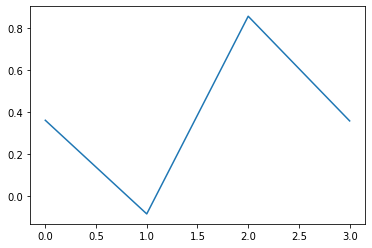

In [49]:
pca = PCA(n_components=2)
pca.fit_transform(iris.data)
print(pca.explained_variance_ratio_)
plt.plot(pca.components_[0])
# plt.imshow(pca.components_[0].reshape(64, 64))
# plt.figure()
# plt.imshow(pca.components_[1].reshape(64, 64))

Text(0.5, 0, 'Number of clusters')

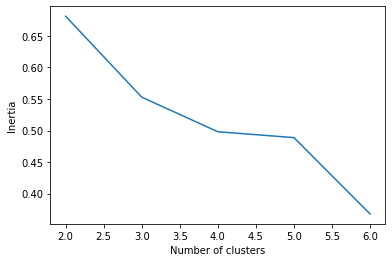

In [58]:
plt.plot(range(2, 7), silhs[:5])
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

In [6]:
def calculate_wcss(data, labels, centers):
    wcss = 0
    for i in range(len(data)):
        cluster_center = centers[labels[i]]
        wcss += np.sum((data[i] - cluster_center) ** 2)
    return wcss
def generate_reference_data(data, nrefs=10, seed=None):
    if seed is not None:
        np.random.seed(seed)
    n, m = data.shape
    reference_data = np.random.random_sample(size=(n, m, nrefs))
    reference_data = (reference_data * (np.max(data) - np.min(data))) + np.min(data)
    return reference_data
def calculate_gap_statistic(data, reference_data, k_values):
    gaps = np.zeros(len(k_values))
    for i, k in enumerate(k_values):
        k_means = KMeans(n_clusters=k)
        k_means.fit(data)
        labels = k_means.predict(data)
        centers = k_means.cluster_centers_
        wcss = calculate_wcss(data, labels, centers)

        reference_wcss = np.zeros(reference_data.shape[2])
        for j in range(reference_data.shape[2]):
            ref_labels = k_means.predict(reference_data[:, :, j])
            ref_centers = k_means.cluster_centers_
            reference_wcss[j] = calculate_wcss(reference_data[:, :, j], ref_labels, ref_centers)

        gaps[i] = np.mean(np.log(reference_wcss) - np.log(wcss))

    return gaps
reference_data = generate_reference_data(iris.data)
gap_values = calculate_gap_statistic(iris.data, reference_data, range(2, 12))



Text(0.5, 1.0, 'Silhouette score')

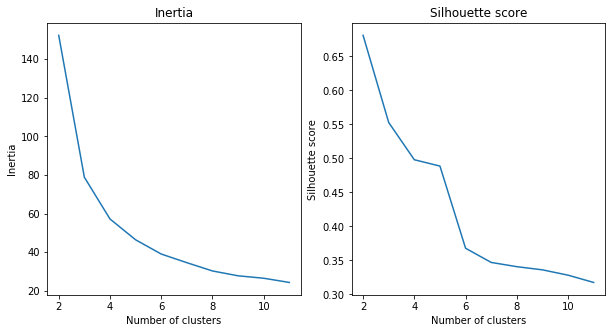

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(2, 12), inters[:10])
ax[0].set_ylabel('Inertia')
ax[0].set_xlabel('Number of clusters')
ax[1].plot(range(2, 12), silhs[:10])
ax[1].set_ylabel('Silhouette score')
ax[1].set_xlabel('Number of clusters')
ax[0].set_title('Inertia')
ax[1].set_title('Silhouette score')


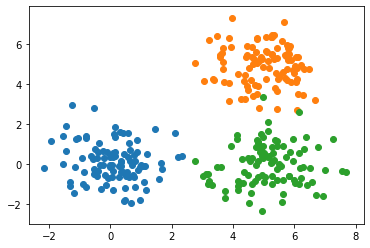

In [9]:
rand1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 100)
rand2 = np.random.multivariate_normal([5, 5], [[1, 0], [0, 1]], 100)
rand3 = np.random.multivariate_normal([5, 0], [[1, 0], [0, 1]], 100)
plt.scatter(rand1[:, 0], rand1[:, 1])
plt.scatter(rand2[:, 0], rand2[:, 1])
plt.scatter(rand3[:, 0], rand3[:, 1])


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


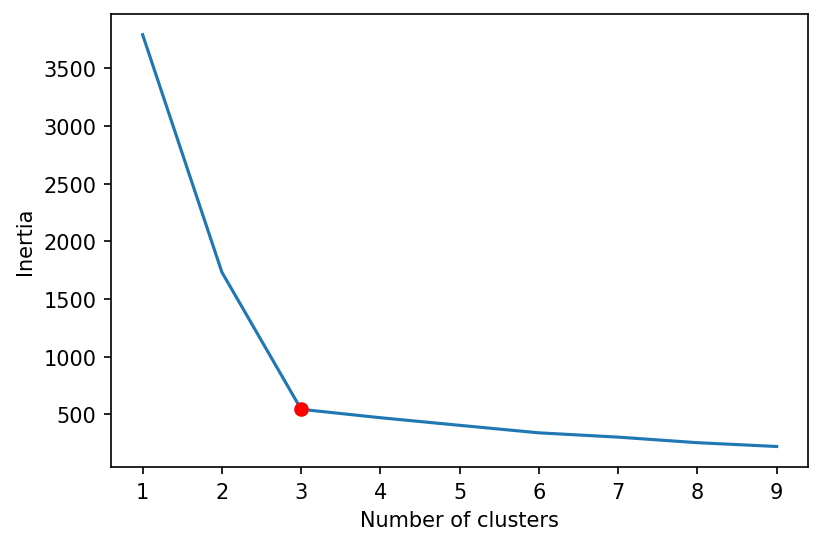

In [16]:
rands = np.concatenate([rand1, rand2, rand3])
rand_inters = []

for i in trange(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rands)
    rand_inters.append(kmeans.inertia_)
plt.figure(dpi=150)
plt.plot(range(1, 10), rand_inters)
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')
plt.scatter([3], rand_inters[2], c='r', zorder=10)

100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


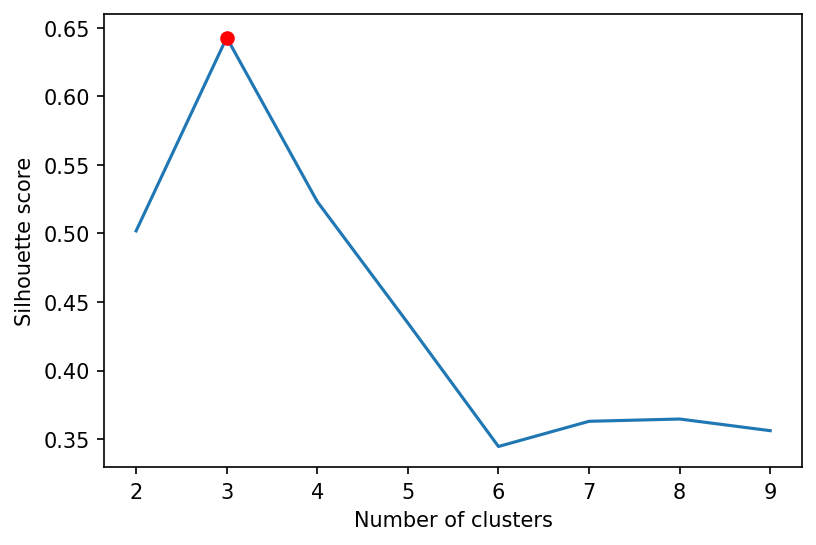

In [19]:
rands = np.concatenate([rand1, rand2, rand3])

silhs = []
for i in trange(2, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rands)
    silhs.append(silhouette_score(rands, kmeans.labels_))
plt.figure(dpi=150)
plt.plot(range(2, 10), silhs)
plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters')
plt.scatter([3], silhs[1], c='r', zorder=10)

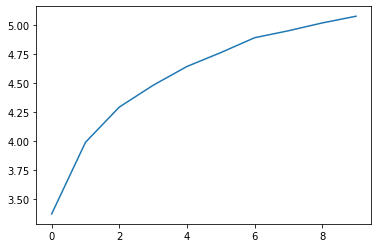

In [7]:
plt.plot(gap_values)

In [ ]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_# Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
        return (gaps.argmax() + 1, resultsdf)
score_g, df = optimalK(iris.data, nrefs=5, maxClusters=30)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

In [25]:
adjusted_rand_score(all_kmeans[3].labels_, iris.target)

0.6124537983599245

Text(0.5, 0, 'Number of clusters')

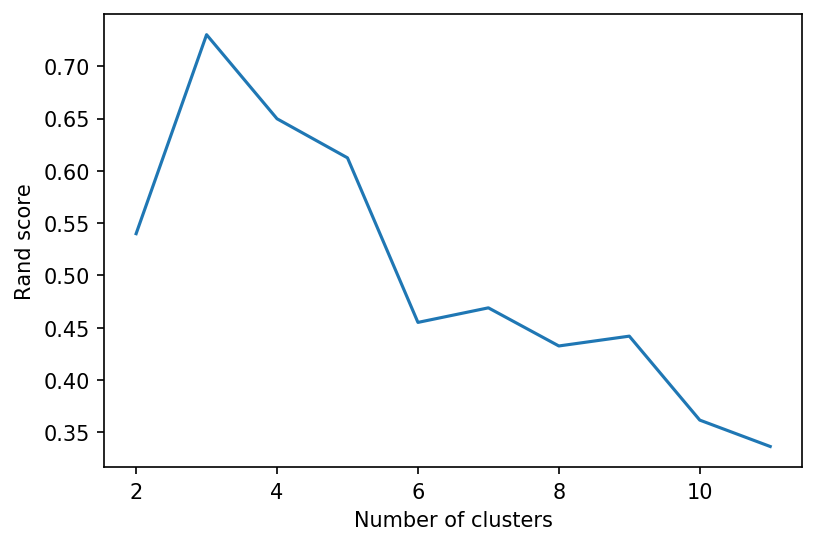

In [40]:
ars = []
plt.figure(dpi=150)
for i in range(0, 10):
    ars.append(adjusted_rand_score(all_kmeans[i].labels_, iris.target))
    #ars.append(accuracy_score(all_kmeans[i].labels_, iris.target))
plt.plot(range(2, 12), ars)
plt.ylabel('Rand score')
plt.xlabel('Number of clusters')

Text(0, 0.5, 'Petal width')

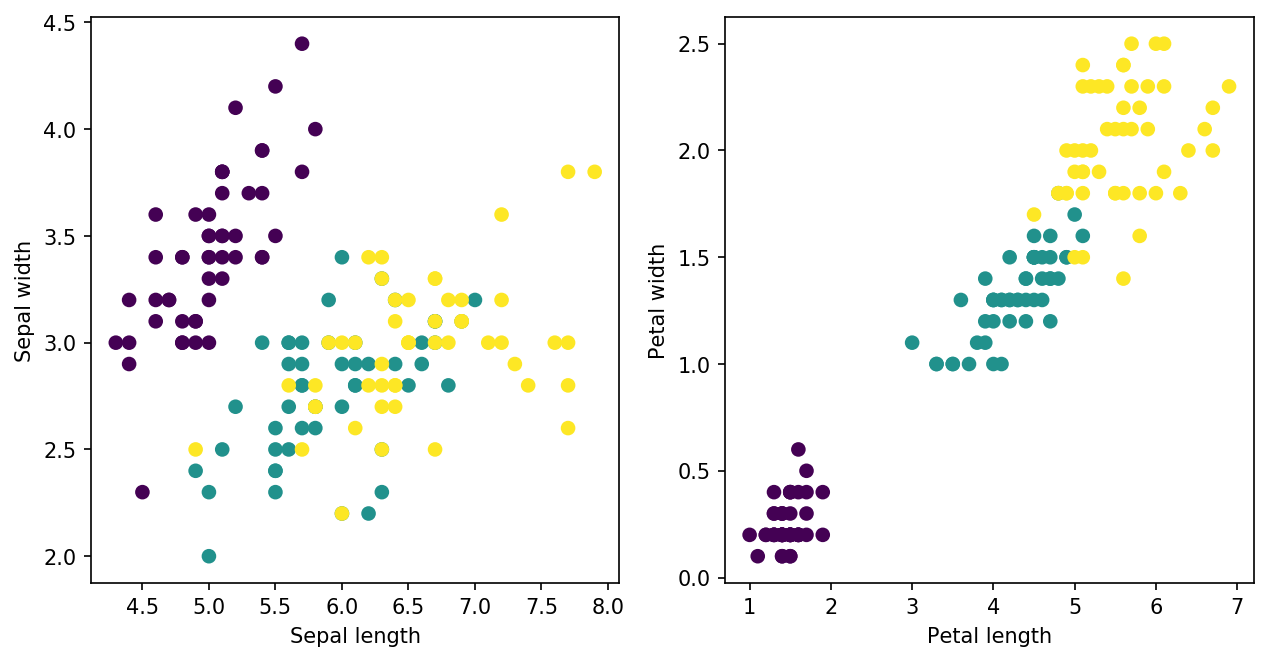

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
ax[0].scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax[0].set_xlabel('Sepal length')
ax[0].set_ylabel('Sepal width')

ax[1].scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target)
ax[1].set_xlabel('Petal length')
ax[1].set_ylabel('Petal width')

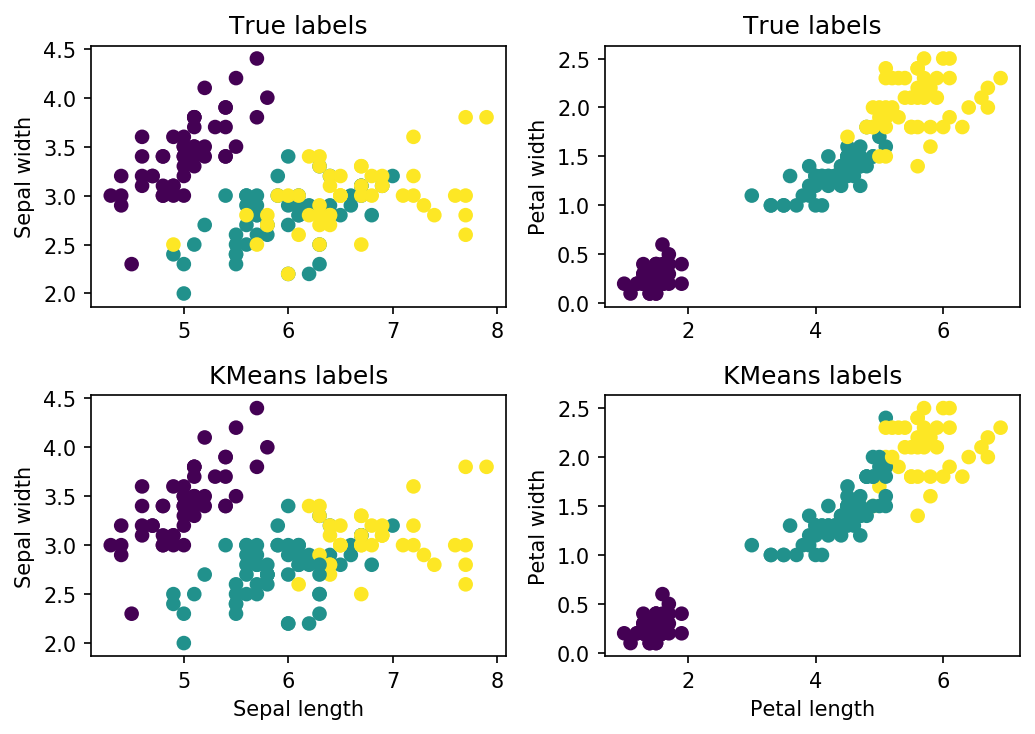

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(7, 5), dpi=150)
ax[0, 0].scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
#ax[0, 0].set_xlabel('Sepal length')
ax[0, 0].set_ylabel('Sepal width')
ax[0, 0].set_title('True labels')

ax[0, 1].scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target)
#ax[0, 1].set_xlabel('Petal length')
ax[0, 1].set_ylabel('Petal width')
ax[0, 1].set_title('True labels')

ax[1, 0].scatter(iris.data[:, 0], iris.data[:, 1], c=all_kmeans[1].labels_)
ax[1, 0].set_xlabel('Sepal length')
ax[1, 0].set_ylabel('Sepal width')
ax[1, 0].set_title('KMeans labels')

ax[1, 1].scatter(iris.data[:, 2], iris.data[:, 3], c=all_kmeans[1].labels_)
ax[1, 1].set_xlabel('Petal length')
ax[1, 1].set_ylabel('Petal width')
ax[1, 1].set_title('KMeans labels')
plt.tight_layout()

Text(0, 0.5, 'Explained variance ratio')

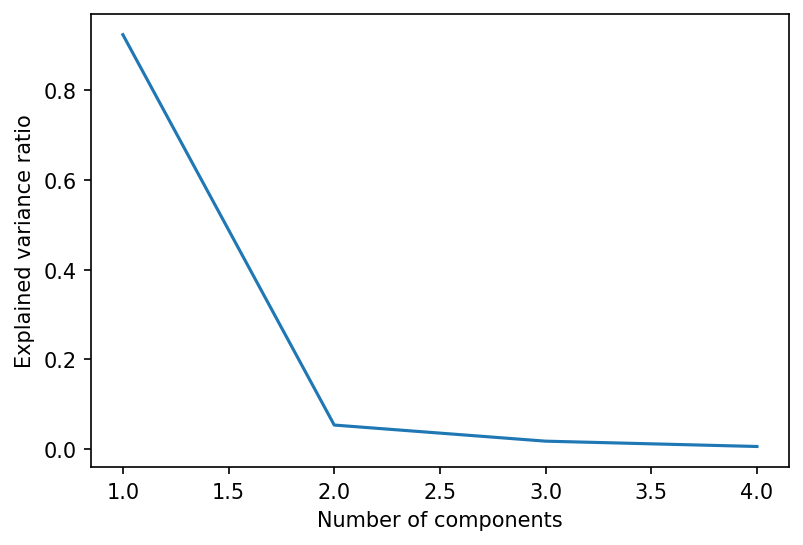

In [75]:
plt.figure(dpi=150)
pca = PCA(n_components=4)
pcad_data = pca.fit(iris.data[:]).transform(iris.data[:])
plt.plot(range(1, 5), pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')

Text(0, 0.5, 'PC2')

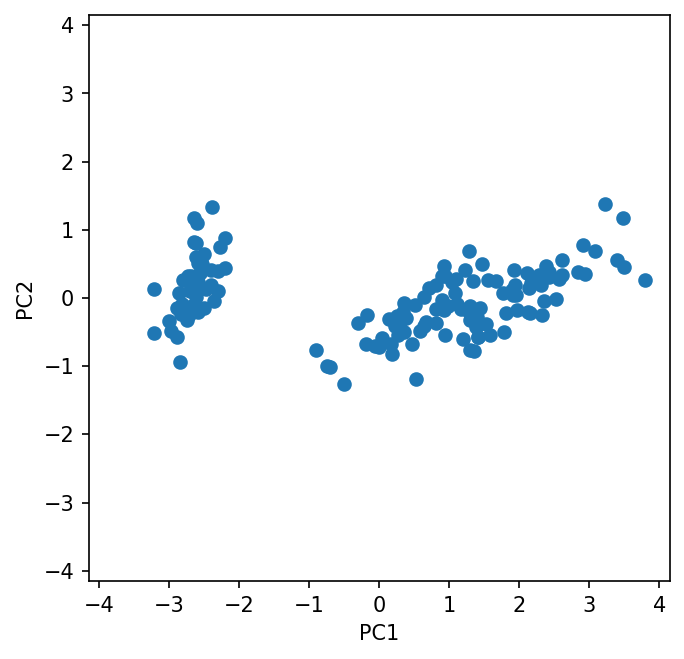

In [76]:
plt.figure(dpi=150, figsize=(5, 5))
plt.scatter(pcad_data[:, 0], pcad_data[:, 1])#, c=(iris.target[50:]), norm= colors.Normalize(vmin=0, vmax=2))
max_lim = np.max(plt.xlim() + plt.ylim())
plt.xlim([-max_lim, max_lim])
plt.ylim([-max_lim, max_lim])
plt.xlabel('PC1')
plt.ylabel('PC2')

In [49]:
print(pca.explained_variance_ratio_)

[0.92461872 0.05306648 0.01710261 0.00521218]


Text(0, 0.5, 'PC1 weights')

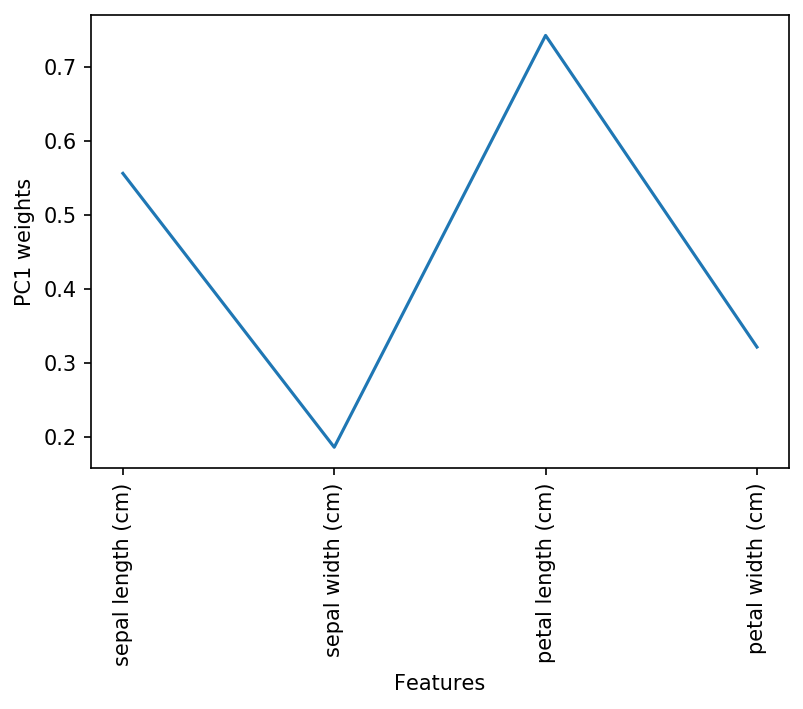

In [73]:
plt.figure(dpi=150)
plt.plot(pca.components_[0])
plt.xticks(range(0, 4), iris.feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('PC1 weights')